In [ ]:
!pip install imbalanced-learn

In [ ]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import GridSearchCV

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from tqdm import tqdm

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1-score: {3:.4f}'.format(accuracy, precision, recall,f1))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
free_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Attack_free_HY_Sonata_train.csv")
free_kia = pd.read_csv("/content/drive/MyDrive/해커톤/Attack_free_KIA_Soul_train.csv")
type1_cv = pd.read_csv("/content/drive/MyDrive/해커톤/Flooding_CHEVROLET_Spark_train.csv")
type1_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Flooding_HYUNDAI_Sonata_train.csv")
type2_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Fuzzy_dataset_HY_Sonata_train.csv")
type2_kia = pd.read_csv("/content/drive/MyDrive/해커톤/Fuzzy_dataset_KIA_Soul_train.csv")
type3_1_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Malfunction_1st_dataset_HY_Sonata_train.csv")
type3_1_kia = pd.read_csv("/content/drive/MyDrive/해커톤/Malfunction_1st_dataset_KIA_Soul_train.csv")
type3_2_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Malfunction_2nd_HY_Sonata_train.csv")
type3_2_kia = pd.read_csv("/content/drive/MyDrive/해커톤/Malfunction_2nd_KIA_Soul_train.csv")
type4_hy = pd.read_csv("/content/drive/MyDrive/해커톤/Replay_dataset_HY_Sonata_train.csv")
type4_kia = pd.read_csv("/content/drive/MyDrive/해커톤/Replay_dataset_KIA_Soul_train.csv")

type3_hy = pd.concat([type3_1_hy,type3_2_hy],axis=0)
type3_kia = pd.concat([type3_1_kia,type3_2_kia],axis=0)

test_df = pd.read_csv("/content/drive/MyDrive/해커톤/test_dataset.csv")

- GAN 참고자료  
https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko  
https://devpanpan.tistory.com/24

- CAN Message 구성  
  - Timestamp - UNIX time 형식의 시간 정보  
    -  UTC 기준 1970년 1월 1일 자정에서부터 현재까지 몇 초가 지났는지를 정수 형태로 표시한다.
  - CAN_ID - CAN ID (식별자) number  
  - DLC - 데이터 필드의 데이터 수 (0~8바이트)  
  - DATA - 데이터 실제 내용  
  - FLAG - 데이터 프레임 타입  
  - TARGET - 차량 상태 레이블 (train.csv에만 존재)  
    *R: Regular (정상 상태)  
    *T: Tampering (공격 상태)  

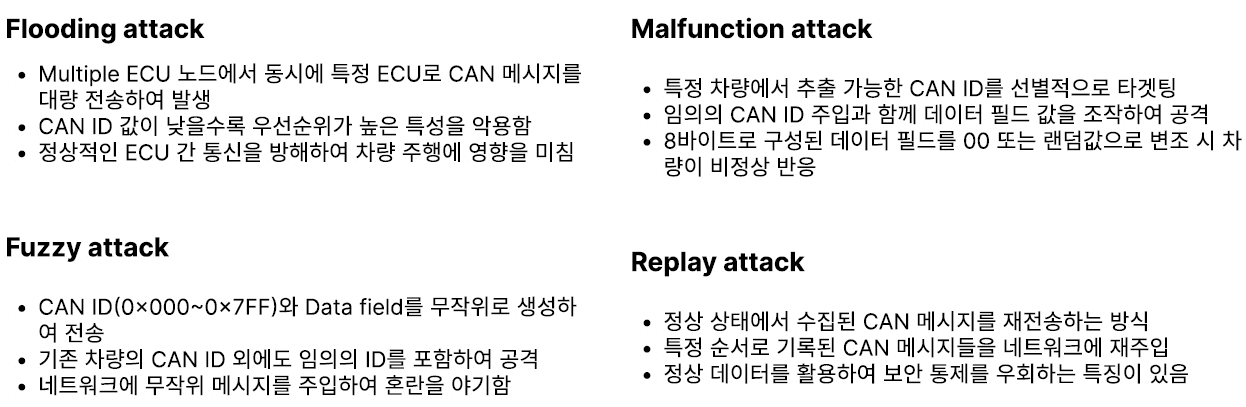

## 공격 유형
### Flooding
- 동시에 메시지를 대량 전송 (-> timestamp 체크)
- CAN ID 값이 낮음

### Fuzzy
- 기존에 등록된 차량 외의 ID를 만들어 공격  
- data에 무작위 값이 입력됨

### Malfunction
- 특정 차량에서 CAN ID를 뽑아 타겟  
- 임의의 CAN ID 주입, data 조작
- data를 00 또는 무작위 값으로 입력

### Replay
- 특정 순서로 기록된 메시지 재전송

## 데이터 전처리

- 파생변수 생성

In [ ]:
def hex_to_dec(value):
    try:
        # 값이 16진수 형식이면 10진수로 변환
        return int(value, 16)
    except ValueError:
        # 변환이 불가능하면 원래 값 반환
        return value

def euclidean_norm(data):
    hex_values = data.split()
    dec_values = np.array([int(x, 16) for x in hex_values])

    euclidean_norm = np.sqrt(np.sum(dec_values ** 2))
    return euclidean_norm

def one_hot_class(data):
    return 1 if data == 'T' else 0

def preprocessing_df(data):
    temp_df = data.copy()

    # Timestamp에 대해 오름차순 정렬
    temp_df = temp_df.sort_values(by='Timestamp').reset_index(drop=True)

    # Timestamp 맞춰주기
    temp_df["Timestamp"] = temp_df["Timestamp"] - 1513920093

    # Timestamp 1
    temp_df["Timestamp1"] = temp_df["Timestamp"].shift(1).fillna(0)

    # Timestamp 2
    temp_df["Timestamp2"] = temp_df["Timestamp"].shift(2).fillna(0)

    # Timestamp 3
    temp_df["Timestamp3"] = temp_df["Timestamp"].shift(3).fillna(0)

    # Timestamp 4
    temp_df["Timestamp4"] = temp_df["Timestamp"].shift(4).fillna(0)

    # Timestamp 5
    temp_df["Timestamp5"] = temp_df["Timestamp"].shift(5).fillna(0)

    # CAN_ID를 10진수로 변환
    temp_df["CAN_ID_encoded"] = temp_df["CAN_ID"].apply(hex_to_dec)

    # DATA의 각 값을 10진수로 변환 후 유클리드 거리 계산
    temp_df["distance"] = temp_df["DATA"].apply(euclidean_norm)

    # DATA 필드를 공백으로 분할
    temp_df['DATA_bytes'] = temp_df['DATA'].str.split(' ')

    # 빈 값을 -1로 채우기
    max_dlc = temp_df['DLC'].max()
    for i in range(max_dlc):
        temp_df[f'DATA_byte_{i}'] = temp_df.apply(
            lambda row: int(row['DATA_bytes'][i], 16) if len(row['DATA_bytes']) > i else -1, axis=1
        )

    # Class 0,1 매핑
    temp_df["Class"] = temp_df["Class"].apply(one_hot_class)

    # 파생변수 - CAN_ID가 0임을 구분하는 binary 변수
    temp_df['CAN_ID_0'] = np.where(temp_df['CAN_ID'] == 0, 1, 0)

    # # 파생변수 - CAN_ID의 출현 빈도에 대한 비율
    # value_ratios = temp_df['CAN_ID_encoded'].value_counts(normalize=True)
    # temp_df['CAN_ID_Ratio'] = temp_df['CAN_ID_encoded'].map(value_ratios)

    # 파생변수 - distance lag
    temp_df.loc[:, 'DATA_lag'] = temp_df.distance.shift(1).fillna(0)

    # 파생변수 - distance lag2
    temp_df.loc[:, 'DATA_lag2'] = temp_df.distance.shift(2).fillna(0)

    # 파생변수 - distance lag3
    temp_df.loc[:, 'DATA_lag3'] = temp_df.distance.shift(3).fillna(0)

    # 파생변수 - distance lag4
    temp_df.loc[:, 'DATA_lag4'] = temp_df.distance.shift(4).fillna(0)

    # 파생변수 - distance lag5
    temp_df.loc[:, 'DATA_lag5'] = temp_df.distance.shift(5).fillna(0)

    # 열 순서 변경
    temp_df = temp_df[['CAN_ID_encoded', 'DLC', 'distance','Timestamp',
                       'DATA_byte_0', 'DATA_byte_1', 'DATA_byte_2', 'DATA_byte_3',
                       'DATA_byte_4', 'DATA_byte_5', 'DATA_byte_6', 'DATA_byte_7',
                       'DATA_lag', 'DATA_lag2', 'DATA_lag3', 'DATA_lag4', 'DATA_lag5',
                       'Timestamp1', 'Timestamp2', 'Timestamp3', 'Timestamp4', 'Timestamp5',
                       'CAN_ID_0', 'Class']]

    return temp_df

데이터 병합

In [ ]:
df_list = [type1_cv,type1_hy,type2_hy,type2_kia,type3_hy,type3_kia,type4_hy,type4_kia]

for i,data in enumerate(df_list):
    data = preprocessing_df(data)

    X_train = data.iloc[:,:-1]
    y_train = data.iloc[:,-1]

    if i == 4 or i == 5:
        new_X_train, new_y_train = SMOTETomek(sampling_strategy=0.8, random_state=100).fit_resample(X_train, y_train)
        new_df = pd.concat([new_X_train, new_y_train],axis=1)
        print(new_df.shape)
    else:
        new_X_train, new_y_train = SMOTE(random_state = 100).fit_resample(X_train, y_train)
        new_df = pd.concat([new_X_train, new_y_train],axis=1)
        print(new_df.shape)

    if i==0:
        combined_df = new_df
    combined_df = pd.concat([combined_df, new_df], axis=0, ignore_index=True)

(46178, 24)
(46090, 24)
(44272, 24)
(41566, 24)
(92188, 24)
(92440, 24)
(40618, 24)
(40754, 24)


In [ ]:
X_train = combined_df.iloc[:,:-1]
y_train = combined_df.iloc[:,-1]

# 스케일링
standard_scaler = StandardScaler()

# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
new_X_train_scaled = standard_scaler.fit_transform(X_train)
# 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
new_X_train_scaled = pd.DataFrame(new_X_train_scaled,
                              index=X_train.index,
                              columns=X_train.columns)

## Feature Importance

distance          0.099078
DATA_byte_3       0.086010
DATA_byte_6       0.082508
CAN_ID_encoded    0.071424
DATA_byte_7       0.060304
Timestamp5        0.056172
DATA_byte_5       0.055323
Timestamp2        0.053033
DATA_byte_4       0.051256
Timestamp1        0.050463
Timestamp3        0.048112
DATA_byte_0       0.047071
Timestamp4        0.046823
DATA_byte_2       0.045515
Timestamp         0.045281
DATA_byte_1       0.045073
DLC               0.012288
DATA_lag5         0.008982
DATA_lag          0.008866
DATA_lag3         0.008861
DATA_lag2         0.008856
DATA_lag4         0.008701
CAN_ID_0          0.000000
dtype: float64


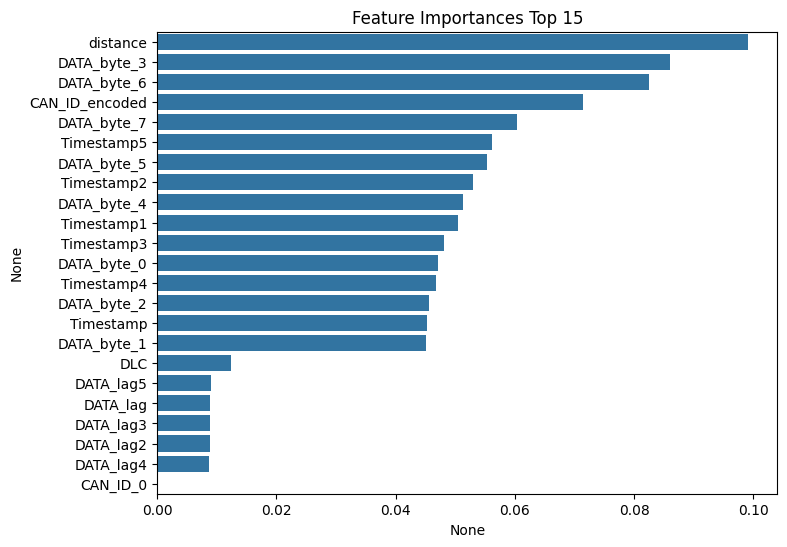

In [ ]:
# 기본설정 랜덤포레스트
rf = RandomForestClassifier(n_jobs=-1) # 모든 코어 사용

# 피쳐중요도만 확인할 것이기 때문에 fit만 한다.
rf.fit(new_X_train_scaled, y_train)

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(rf.feature_importances_, index=new_X_train_scaled.columns)

# 내림차순 정렬을 이용한다
top15 = ser.sort_values(ascending=False)[:25]
print(top15)

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

피쳐 선정

In [ ]:
temp_df2 = combined_df[['Timestamp','CAN_ID_encoded',
                        'DATA_byte_0', 'DATA_byte_1', 'DATA_byte_2', 'DATA_byte_3',
                        'DATA_byte_4', 'DATA_byte_5', 'DATA_byte_6', 'DATA_byte_7',
                        'Timestamp1', 'Timestamp2', 'Timestamp3', 'Timestamp4', 'Timestamp5',
                        'Class']]

In [ ]:
temp_df2

,Timestamp,CAN_ID_encoded,DATA_byte_0,DATA_byte_1,DATA_byte_2,DATA_byte_3,DATA_byte_4,DATA_byte_5,DATA_byte_6,DATA_byte_7,Timestamp1,Timestamp2,Timestamp3,Timestamp4,Timestamp5,Class
0,1,398.0,0,0,0,105,150,152,6,152,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,419.0,128,-1,-1,-1,-1,-1,-1,-1,1.000000,0.000000,0.000000,0.000000,0.000000,0
2,1,479.0,128,2,0,0,-1,-1,-1,-1,1.000000,1.000000,0.000000,0.000000,0.000000,0
3,1,426.0,0,104,118,137,106,160,0,-1,1.000000,1.000000,1.000000,0.000000,0.000000,0
4,1,1000000000.0,0,16,0,14,15,254,0,0,1.000000,1.000000,1.000000,1.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490279,4068,544.0,236,3,243,3,9,0,67,16,4068.496730,4068.496730,4068.496730,4068.496730,4068.496730,1
490280,3928,1250.078765,0,0,0,0,0,0,0,0,3928.989459,3928.989459,3928.989459,3928.989459,3928.989459,1
490281,3911,880.0,255,32,0,128,255,0,0,77,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,1
490282,4087,1230.58221,0,0,0,0,0,0,0,0,4087.787215,4087.787215,4087.787215,4087.787215,4087.787215,1


In [ ]:
X = temp_df2.iloc[:,:-1]
y = temp_df2.iloc[:,-1]

# 스케일링
standard_scaler = StandardScaler()

# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
new_X_train_scaled = standard_scaler.fit_transform(X)
# 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
new_X_train_scaled = pd.DataFrame(X,
                              index=X.index,
                              columns=X.columns)

## ExtraTreeClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X_train_scaled, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=42)

# 하이퍼파라미터 후보
param_grid = {
    'n_estimators': [500],
    'criterion': ['entropy'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',   # 평가 지표 (필요에 따라 변경 가능)
    cv=5,                 # 교차검증 분할 수
    n_jobs=-1
)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 점수 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적의 점수: {grid_search.best_score_}")

최적의 하이퍼파라미터: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
최적의 점수: 0.9723687215478325


test_df로 예측

In [ ]:
def hex_to_dec(value):
    try:
        # 값이 16진수 형식이면 10진수로 변환
        return int(value, 16)
    except ValueError:
        # 변환이 불가능하면 원래 값 반환
        return value

def euclidean_norm(data):
    hex_values = data.split()
    dec_values = np.array([int(x, 16) for x in hex_values])

    euclidean_norm = np.sqrt(np.sum(dec_values ** 2))
    return euclidean_norm

def one_hot_class(data):
    return 1 if data == 'T' else 0

def preprocessing_test_df(data):
    temp_df = data.copy()

    # Timestamp에 대해 오름차순 정렬
    temp_df = temp_df.sort_values(by='Timestamp').reset_index(drop=True)

    # Timestamp 맞춰주기
    temp_df["Timestamp"] = temp_df["Timestamp"] - 1513920093

    # Timestamp 1
    temp_df["Timestamp1"] = temp_df["Timestamp"].shift(1).fillna(0)

    # Timestamp 2
    temp_df["Timestamp2"] = temp_df["Timestamp"].shift(2).fillna(0)

    # Timestamp 3
    temp_df["Timestamp3"] = temp_df["Timestamp"].shift(3).fillna(0)

    # Timestamp 4
    temp_df["Timestamp4"] = temp_df["Timestamp"].shift(4).fillna(0)

    # Timestamp 5
    temp_df["Timestamp5"] = temp_df["Timestamp"].shift(5).fillna(0)

    # CAN_ID를 10진수로 변환
    temp_df["CAN_ID_encoded"] = temp_df["CAN_ID"].apply(hex_to_dec)

    # DATA의 각 값을 10진수로 변환 후 유클리드 거리 계산
    temp_df["distance"] = temp_df["DATA"].apply(euclidean_norm)

    # DATA 필드를 공백으로 분할
    temp_df['DATA_bytes'] = temp_df['DATA'].str.split(' ')

    # 빈 값을 -1로 채우기
    max_dlc = temp_df['DLC'].max()
    for i in range(max_dlc):
        temp_df[f'DATA_byte_{i}'] = temp_df.apply(
            lambda row: int(row['DATA_bytes'][i], 16) if len(row['DATA_bytes']) > i else -1, axis=1
        )

    # 열 순서 변경
    temp_df = temp_df[['CAN_ID_encoded', 'distance','Timestamp',
                       'DATA_byte_0', 'DATA_byte_1', 'DATA_byte_2', 'DATA_byte_3',
                       'DATA_byte_4', 'DATA_byte_5', 'DATA_byte_6', 'DATA_byte_7',
                       'Timestamp1', 'Timestamp2', 'Timestamp3', 'Timestamp4', 'Timestamp5']]

    return temp_df

new_test_df = preprocessing_test_df(test_df)[['Timestamp','CAN_ID_encoded',
                        'DATA_byte_0', 'DATA_byte_1', 'DATA_byte_2', 'DATA_byte_3',
                        'DATA_byte_4', 'DATA_byte_5', 'DATA_byte_6', 'DATA_byte_7',
                        'Timestamp1', 'Timestamp2', 'Timestamp3', 'Timestamp4', 'Timestamp5']]

new_test_df_scaled = standard_scaler.fit_transform(new_test_df)
new_test_df_scaled = pd.DataFrame(new_test_df,
                              index=new_test_df.index,
                              columns=new_test_df.columns)

# 최적 모델로 예측 수행
best_model = grid_search.best_estimator_

# 테스트 데이터에 대해 예측
y_pred = best_model.predict(new_test_df_scaled)

In [ ]:
pd.Series(y_pred).value_counts()

,count
0,122511
1,21501


행 순서 다시 찾아주기

In [ ]:
aa = test_df.sort_values(by='Timestamp').reset_index(drop=False); aa

,index,ID,Timestamp,CAN_ID,DLC,DATA
0,7974,7975,1513920094,00BE,6,00 00 00 03 E8 00
1,2898,2899,1513920094,03F9,8,00 A4 2D 71 5F 38 FF 35
2,3040,3041,1513920094,210,4,02 00 01 FF
3,2992,2993,1513920094,00BE,6,04 00 00 03 E9 FF
4,4522,4523,1513920094,00C5,8,13 52 0F 1D D3 F4 03 D4
...,...,...,...,...,...,...
144007,111556,111557,1513925509,545,8,D8 00 00 8D 00 00 00 00
144008,117811,117812,1513925509,02C0,8,14 00 00 00 00 00 00 00
144009,119593,119594,1513925509,153,8,00 21 10 FF 00 FF 00 00
144010,113993,113994,1513925509,05F0,2,00 00


In [ ]:
final_df = pd.concat([aa['index'],pd.Series(y_pred)],axis=1)

df_sorted = final_df.sort_values(by="index").reset_index(drop=True)
df_sorted.columns = ['index','Class']

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/해커톤/submission.csv")

In [ ]:
def restore_class(data):
    return 'T' if data == 1 else 'R'

In [ ]:
sub.Class = df_sorted.Class
sub.Class = sub.Class.apply(restore_class)

In [ ]:
sub.to_csv("/content/drive/MyDrive/해커톤/submission_new.csv",index=False)